In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Pacotes enviados/recebidos, PDR e E2E Delay
# Entra na pasta do cenário, depois digita: opp_scavetool x *.sca -o nome_do_csv.csv

# ==========================================================    
# Declaração de constantes
# ==========================================================    

CSV_DIR = "../csv/"
OUT_FILE = "pacotes_e2e_medias.csv"
OUT_FILE_CONSOLIDADO = "pacotes_e2e_medias_consolidado.csv"
DIC_SPEED = {
    "Static": 0,
    "IPv4SlowMobility": 1,
    "IPv4ModerateFastMobility": 2,
    "IPv4FastMobility": 3,
    "IPv4Fast4Mobility": 4,
    "IPv4Fast5Mobility": 5,
    "IPv4Fast6Mobility": 6,
}

# ==========================================================    
# Verifica se o arquivo de saída já foi gerado e lê
# ==========================================================    

if os.path.isfile(join(CSV_DIR, OUT_FILE)):
    df_cenarios = pd.read_csv(join(CSV_DIR, OUT_FILE), low_memory = False)
else:
    # ==========================================================    
    # Leitura de todos os .csv e criação do dataframe único
    # ==========================================================

    csv_files = [f for f in listdir(CSV_DIR) if (isfile(join(CSV_DIR, f)) and '~lock' not in f and OUT_FILE not in f)]

    data_frames = []
    for f in csv_files:
        df = pd.read_csv(join(CSV_DIR, f), low_memory = False)
        scenario = f.replace(".csv", "")
        info = scenario.split("_")
        df["scenario"] = scenario
        df["speed"] = DIC_SPEED[info[0]]
        df["hosts"] = info[1]
        df["timeout"] = info[2]
        data_frames.append(df)

    df_cenarios = pd.DataFrame(columns = ["scenario", "speed", "hosts", "timeout", "run", "round_idx", "pck_sent", "pck_rec", "pdr", "e2e_mean", "e2e_stddev"])
    for df in data_frames:
        # Filtra as linhas pra pegar só os pacotes enviados/recebidos e as info de E2E 
        sent = df.query('name=="packets sent" & module=="AODVNetwork_cbr.aodvCli.app[0]" & type=="scalar"')
        rec = df.query('name=="packetReceived:count" & module=="AODVNetwork_cbr.aodvSrv.app[0]" & type=="scalar"')
        e2e = df.query('name=="endToEndDelay:histogram" & module=="AODVNetwork_cbr.aodvSrv.app[0]" & type=="histogram"')

        # Cria um data frame contendo scenario|speed|hosts|timeout|run|round.idx|pck.sent|pck.rec|pdr|e2e.mean|e2e.stddev
        data = pd.merge(sent, rec, on = "run")
        data = pd.merge(e2e, data, on = "run")
        data = pd.DataFrame(
            {"scenario": data["scenario"],
             "speed": pd.to_numeric(data["speed"]),
             "hosts": pd.to_numeric(data["hosts"]),
             "timeout": pd.to_numeric(data["timeout"]),
             "run": data["run"],
             "pck_sent": pd.to_numeric(data["value_x"]),
             "pck_rec": pd.to_numeric(data["value_y"]),
             "pdr": pd.to_numeric(data["value_y"]) / pd.to_numeric(data["value_x"]),
             "e2e_mean": data["mean"],
             "e2e_stddev": data["stddev"],
            }
        )
        df_cenarios = df_cenarios.append(data, ignore_index = True)
    df_cenarios["round_idx"] = df_cenarios["run"].str.extract('\-(\d+)\-')

speed  hosts  timeout
0.0    10.0   3.0        30
              5.0        30
              10.0       30
       20.0   3.0        30
              5.0        30
              10.0       30
       30.0   3.0        30
              5.0        30
              10.0       30
1.0    10.0   3.0        30
              5.0        30
              10.0       30
       20.0   3.0        30
              5.0        30
              10.0       30
       30.0   3.0        30
              5.0        30
              10.0       30
2.0    10.0   3.0        30
              5.0        30
              10.0       30
       20.0   3.0        30
              5.0        30
              10.0       30
       30.0   3.0        30
              5.0        30
              10.0       30
3.0    10.0   3.0        30
              5.0        30
              10.0       30
       20.0   3.0        30
              5.0        30
              10.0       30
       30.0   3.0        30
              5.0        3

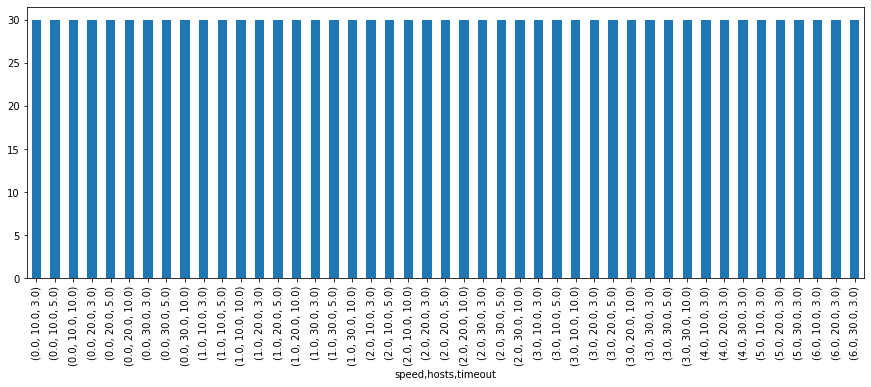

In [3]:
# ==========================================================    
# Ajustes manuais
# ==========================================================

# Remove as rodadas inválidas onde não houve recebimento de pacotes
df_cenarios = df_cenarios.query('pck_rec>0')
df_aux = pd.DataFrame().reindex_like(df_cenarios)
n_samples = 30

for speed in [0, 1, 2, 3, 4, 5, 6]:
    for hosts in [10, 20, 30]:
        for timeout in [3, 5, 10]:
            df_query = df_cenarios.query('speed == {0} and hosts == {1} and timeout == {2}'.format(speed, hosts, timeout))
            df_aux = df_aux.append(df_query.sample(n = n_samples if len(df_query.index) > n_samples else len(df_query.index), replace = False), ignore_index = True)

# Plota a quantidade de instâncias de cada cenário para conferência (deve ser 'n_samples')
grouped = df_aux.groupby(by = ['speed', 'hosts', 'timeout'])
qtd = grouped['pck_rec'].count()
plt.figure(figsize = (15, 5))
qtd.plot.bar();     
qtd

In [5]:
# Salva dataframe em CSV
df_cenarios = df_aux.dropna()
df_cenarios.to_csv(join(CSV_DIR, OUT_FILE))

# Salva dataframe consolidado em CSV
df_cenarios.query('timeout == 3').groupby(by = ['speed', 'hosts', 'timeout']).agg({
'pdr': ['min', 'max', 'median', 'mean', 'std'],
'e2e_mean': ['min', 'max', 'median', 'mean', 'std']}).to_csv(join(CSV_DIR, OUT_FILE_CONSOLIDADO))

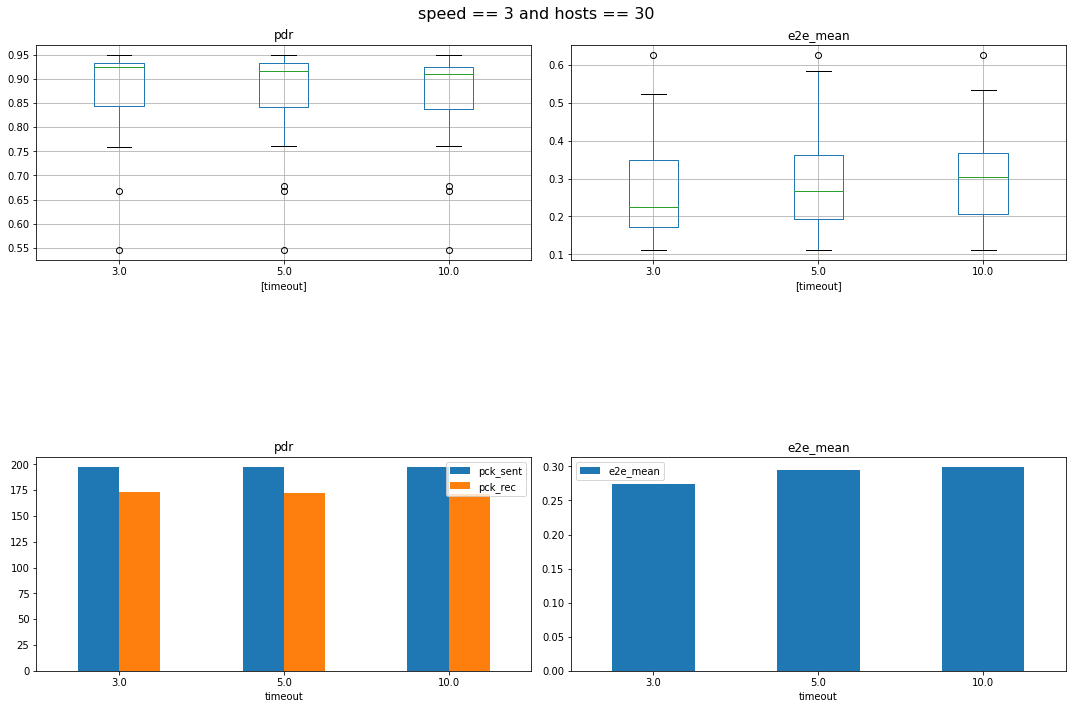

In [6]:
# Comparativo entre todos os cenários
# Pode escolher as variáveis agregadoras: 'speed', 'hosts', 'timeout'
# Pode escolher as variáveis computadas: 'pdr', 'e2e_mean'
qry = "speed == 3 and hosts == 30"
df = df_cenarios.query(qry)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.tight_layout(h_pad = 15.0)

ax = df.boxplot(column = 'pdr', by = ['timeout'], ax = axes[0, 0]);
for label in ax.get_xticklabels(): 
  label.set_rotation(0)

ax = df.boxplot(column = 'e2e_mean', by = ['timeout'], ax = axes[0, 1]);
for label in ax.get_xticklabels(): 
  label.set_rotation(0)

ax = df.groupby(by = ['timeout']).agg({'pck_sent': 'mean', 'pck_rec': 'mean'}).plot(y = ['pck_sent', 'pck_rec'], ax = axes[1, 0], kind = 'bar');
ax.set_title("pdr")
for label in ax.get_xticklabels(): 
  label.set_rotation(0)

ax = df.groupby(by = ['timeout']).agg({'e2e_mean': 'mean'}).plot(y = 'e2e_mean', ax = axes[1, 1], kind = 'bar');
ax.set_title("e2e_mean")
for label in ax.get_xticklabels(): 
  label.set_rotation(0)

fig.suptitle(qry, fontsize = 16);
fig.tight_layout(h_pad = 15.0)

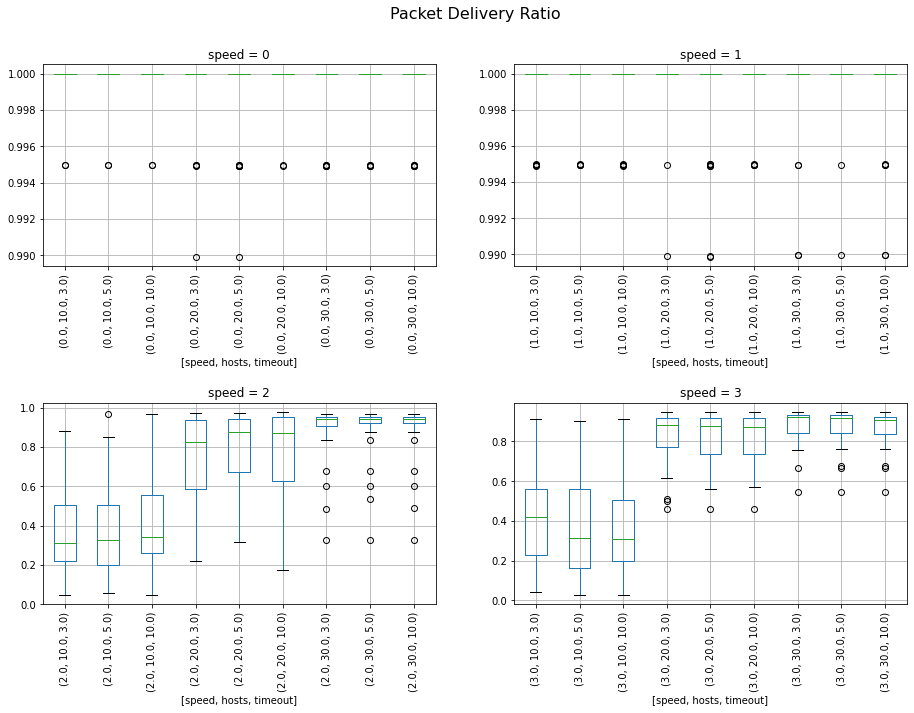

In [7]:
# Plota o comparativo do PDR entre os cenários na forma de boxplot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.tight_layout(h_pad = 15.0)

# Speed = 0
ax = df_cenarios.query('speed == 0').boxplot(column = 'pdr', by = ['speed', 'hosts', 'timeout'], ax = axes[0, 0]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90)
ax.set_title('speed = 0');

# Speed = 1
ax = df_cenarios.query('speed == 1').boxplot(column = 'pdr', by = ['speed', 'hosts', 'timeout'], ax = axes[0, 1]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90) 
ax.set_title('speed = 1');

# Speed = 2
ax = df_cenarios.query('speed == 2').boxplot(column = 'pdr', by = ['speed', 'hosts', 'timeout'], ax = axes[1, 0]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90)
ax.set_title('speed = 2');

# Speed = 3
ax = df_cenarios.query('speed == 3').boxplot(column = 'pdr', by = ['speed', 'hosts', 'timeout'], ax = axes[1, 1]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90) 
ax.set_title('speed = 3');
fig.suptitle('Packet Delivery Ratio', fontsize=16);

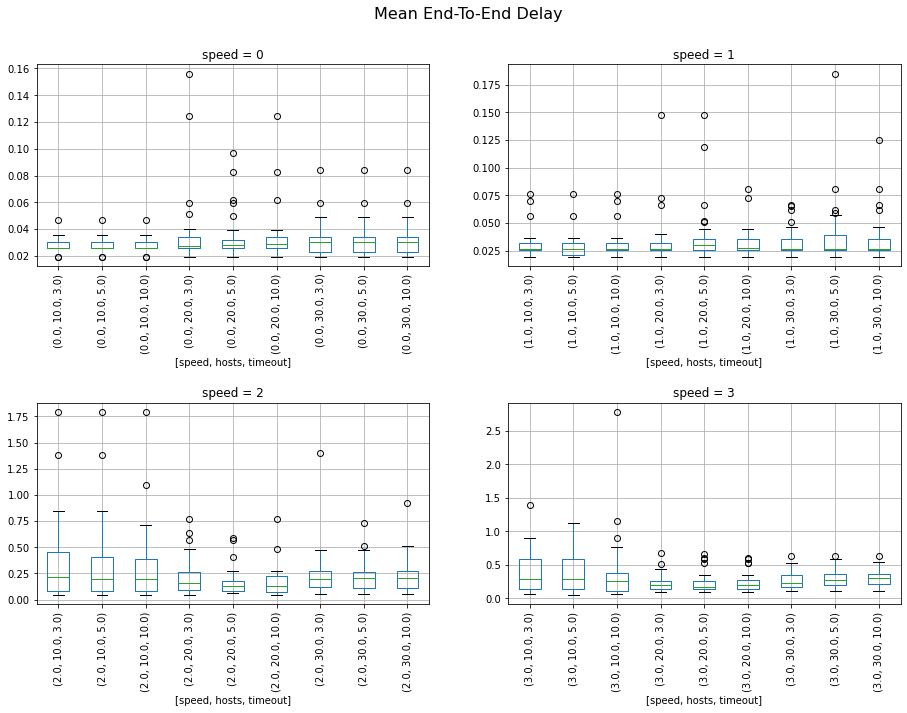

In [8]:
# Plota o comparativo do E2E Delay entre os cenários na forma de boxplot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.tight_layout(h_pad = 15.0)

# Speed = 0
ax = df_cenarios.query('speed == 0').boxplot(column = 'e2e_mean', by = ['speed', 'hosts', 'timeout'], ax = axes[0, 0]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90)
ax.set_title('speed = 0');

# Speed = 1
ax = df_cenarios.query('speed == 1').boxplot(column = 'e2e_mean', by = ['speed', 'hosts', 'timeout'], ax = axes[0, 1]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90) 
ax.set_title('speed = 1');

# Speed = 2
ax = df_cenarios.query('speed == 2').boxplot(column = 'e2e_mean', by = ['speed', 'hosts', 'timeout'], ax = axes[1, 0]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90)
ax.set_title('speed = 2');

# Speed = 3
ax = df_cenarios.query('speed == 3').boxplot(column = 'e2e_mean', by = ['speed', 'hosts', 'timeout'], ax = axes[1, 1]);
for label in ax.get_xticklabels(): 
  label.set_rotation(90) 
ax.set_title('speed = 3');
fig.suptitle('Mean End-To-End Delay', fontsize=16);

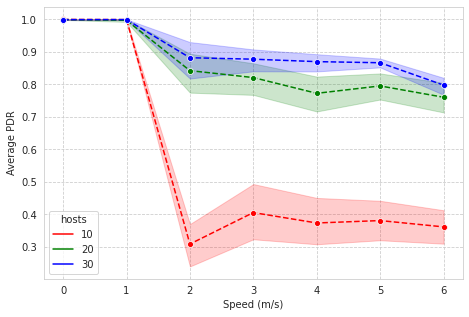

In [5]:
# Average PDR
timeout = 3
ci = 95
fig, ax = plt.subplots(figsize = (7.5, 5))
ax.xaxis.grid(True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
df = df_cenarios.query('timeout == {0}'.format(timeout))
df['hosts'] = df['hosts'].astype(int)
g = sns.lineplot(data = df, x = 'speed', y = 'pdr', hue = 'hosts', ax = ax, palette = ['red', 'green', 'blue'], marker = 'o', linestyle = "dashed", err_style = "band", ci = ci, estimator = np.mean);
g.set_xticks(range(7))
g.set(xlabel = "Speed (m/s)", ylabel = "Average PDR", title = None)
plt.show()

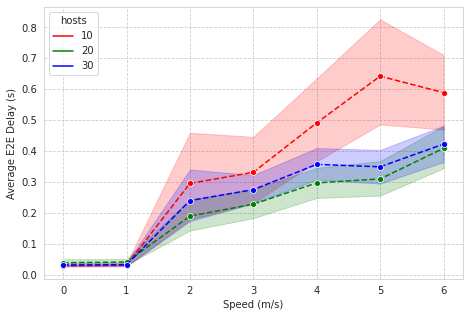

In [6]:
# E2E Delay x Speed x Hosts
timeout = 3
ci = 95
fig, ax = plt.subplots(figsize = (7.5, 5))
ax.xaxis.grid(True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
df = df_cenarios.query('timeout == {0}'.format(timeout))
df['hosts'] = df['hosts'].astype(int)
g = sns.lineplot(data = df, x = 'speed', y = 'e2e_mean', hue = 'hosts', ax = ax, palette = ['red', 'green', 'blue'], marker = 'o', linestyle = "dashed", err_style = "band", ci = ci, estimator = np.mean);
plt.legend(loc = 'upper left', title = 'hosts')
g.set_xticks(range(7))
g.set(xlabel = "Speed (m/s)", ylabel = "Average E2E Delay (s)", title = None)
plt.show()

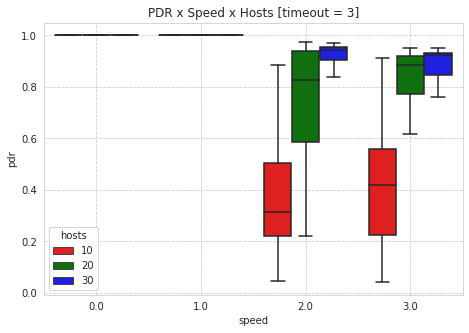

In [40]:
fig, ax = plt.subplots(figsize = (7.5, 5))
df = df_cenarios.query('timeout == 3')
df['hosts'] = df['hosts'].astype(int)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(data = df, x = 'speed', y = 'pdr', hue = 'hosts', ax = ax, palette = ['red', 'green', 'blue'], showfliers = False);
g.set_xticks(range(4))
ax.xaxis.grid(True)
g.set_title("PDR x Speed x Hosts [timeout = 3]")
plt.show()

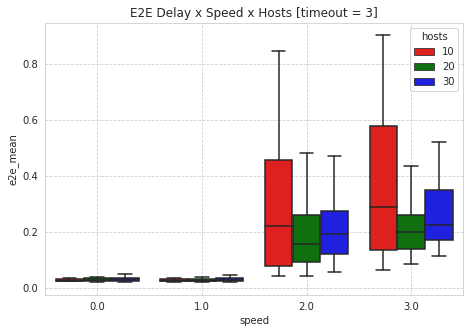

In [41]:
fig, ax = plt.subplots(figsize = (7.5, 5))
df = df_cenarios.query('timeout == 3')
df['hosts'] = df['hosts'].astype(int)
g = sns.boxplot(data = df, x = 'speed', y = 'e2e_mean', hue = 'hosts', ax = ax, palette = ['red', 'green', 'blue'], showfliers = False);
g.set_xticks(range(4))
g.set_title("E2E Delay x Speed x Hosts [timeout = 3]")
ax.xaxis.grid(True)
plt.show()